# Dissonancereduction

In [1]:
from adaptivetuning import Dissonancereduction
import numpy as np

<IPython.core.display.Javascript object>

A Dissonancereduction object provides methods to fine-tune a set of complex tones to reduce their dissonance as defined by the beating theory of dissonance. That includes both the dissonance they produce with each other and the dissonance they produce with a given set of fixed simple tones.

## Explanation

Construct an example first, an A major piano chord in closed position with added octave (A4, C#5, E5, A4) in 12TET.

In [2]:
ji_intervals = [1, 16/15, 9/8, 6/5, 5/4, 4/3, 45/32, 3/2, 8/5, 5/3, 9/5, 15/8, 2]
partials_vol_piano = np.array([3.7, 5.4, 1.2, 1.1, 0.95, 0.6, 0.5, 0.65, 0.001, 0.1, 0.2]) / 5.4

notes = [0, 4, 7, 12]
et_fundamentals = [440 * 2**(i/12) for i in notes]  # equal tempered version of that chord
ji_fundamentals = [440 * ji_intervals[i] for i in notes]  # just version
fundamentals_vol = np.ones(len(notes))
partials_pos = list(range(1, len(partials_vol_piano) + 1))
partials_vol = partials_vol_piano

The partials of the tonic are used as fixed positions, the rest is to be tuned.

In [3]:
fixed_freq = [et_fundamentals[0] * p for p in partials_pos]
fixed_vol = [fundamentals_vol[0] * v for v in partials_vol]

In [4]:
dissonancereduction = Dissonancereduction(method='CG', relative_bounds=None)

First factors that we treat as constants during optimization are calculated.

In [5]:
relevant_pairs, critical_bandwidths, volume_factors = dissonancereduction.quasi_constants(
    np.array(et_fundamentals[1:]), np.array(fundamentals_vol[1:]),
    np.array(partials_pos), np.array(partials_vol),
    np.array(fixed_freq), np.array(fixed_vol))

Dropping pairs with volume factor = 0 or distance > 1.46 x critical bandwidth reduces the amount of relevant pairs from 1210 to 140.

In [6]:
len(relevant_pairs)

140

If [i,k,j,l] in relevant_pairs than the kth partial of the ith complex tone and the lth partial of the jth overtone form a relevant pair. If l = -1, j, l refers to the jth fixed frequency instead.

The second overtone of the tonic (2, -1) and the first overtone of the fifths (1, 1) are close -> relevant.

In [7]:
[1, 1, 2, -1] in relevant_pairs.tolist()

True

The fundamental of the tonic (0, -1) and the first overtone of the fifths (1, 1) are not close -> irrelevant.

In [8]:
[1, 1, 0, -1] in relevant_pairs.tolist()

False

The eighth overtones of the third and fifths are close -> relevant.

In [9]:
[0, 8, 1, 8] in relevant_pairs.tolist()

True

But the eighth overtones of our timbre are weak, so the volume factor is small.

In [10]:
volume_factors[relevant_pairs.tolist().index([0, 8, 1, 8])]

0.8608141448259226

The first overtones are strong -> big volume factor.

In [11]:
volume_factors[relevant_pairs.tolist().index([0, 1, 1, 1])]

4.5313189239810825

First overtones of the third and the fifths ([0, 1, 1, 1]) are approximately at 1200 HZ where the critical bandwidth is approximately 200 Hz, our approximation is very rough of course.

In [12]:
critical_bandwidths[relevant_pairs.tolist().index([0, 1, 1, 1])]

187.33314724834622

Third overtones of the third and the fifths ([0, 3, 1, 3]) are approximately at 2400 HZ where the critical bandwidth is approximately 380 Hz.

In [13]:
critical_bandwidths[relevant_pairs.tolist().index([0, 3, 1, 3])]

373.04659900888373

In [14]:
dissonance, gradient = dissonancereduction.dissonance_and_gradient(
    np.array(et_fundamentals[1:]), np.array(partials_pos), np.array(fixed_freq),
    np.array(critical_bandwidths), np.array(volume_factors), np.array(relevant_pairs))

The most dissonant note of an equal tempered major chord is the major third which is to sharp -> the biggest value of the gradient is the one corresponding to the major third and the negative gradient is pointing in the negative direction, corresponding to a down-tuning of the third.

In [15]:
gradient

array([ 0.00593165, -0.00090389, -0.0016534 ])

In [16]:
result = dissonancereduction.tune(np.array(et_fundamentals[1:]), np.array(fundamentals_vol[1:]),
                                  np.array(partials_pos), np.array(partials_vol),
                                  np.array(fixed_freq), np.array(fixed_vol))

In [17]:
result

     fun: 0.8749162471402305
     jac: array([0.0003685, 0.0004641, 0.0003907])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 116
     nit: 2
    njev: 104
  status: 2
 success: False
       x: array([549.95398172, 659.90390223, 880.66548775])

The resulting chord is more similar to a just major chord than to a equal tempered major chord:

In [112]:
def freq_to_cent(freqs):
    return [int(round(1200 * np.log2(f / freqs[0]))) for f in freqs]

In [113]:
freq_to_cent([et_fundamentals[0]] + result['x'].tolist())

[0, 387, 701, 1201]

In [114]:
freq_to_cent(et_fundamentals)

[0, 400, 700, 1200]

In [115]:
freq_to_cent(ji_fundamentals)

[0, 386, 702, 1200]

## Dissonance curve

In [50]:
import matplotlib.pyplot as plt

This is what the dissonance curve of the dissonance measure implemented in Dissonancereduction looks like:

In [47]:
dissonancereduction = Dissonancereduction()

In [48]:
base_freq = 440
partials_pos = list(range(1, len(partials_vol_piano) + 1))
partials_vol = partials_vol_piano

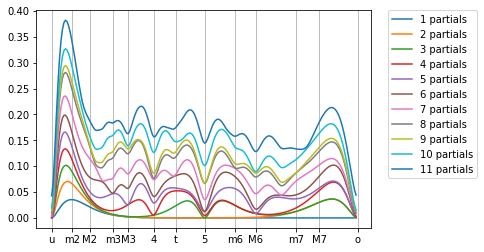

In [52]:
intervals = np.arange(1, 2, 0.005)

fig, ax = plt.subplots()

for nr in range(1, 12):
    ax.plot(intervals, np.vectorize(
        lambda interval: dissonancereduction.single_dissonance_and_gradient(
            [base_freq, base_freq * interval], [1, 1],
            partials_pos[:nr], partials_vol[:nr]
        )[0]
    )(intervals), label='%i partials' % nr)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# reference intevals for the grid:
ju_intervals = [1, 16/15, 9/8, 6/5, 5/4, 4/3, 45/32, 3/2, 8/5, 5/3, 9/5, 15/8, 2]
et_intervals = [2**(i/12) for i in range(0,13)]
degree_names = ['u', 'm2', 'M2', 'm3', 'M3', '4', 't', '5', 'm6', 'M6', 'm7', 'M7', 'o']

ax.set_xticks(ju_intervals)
ax.set_xticklabels(degree_names)
ax.xaxis.grid(True)
plt.show()

Not how the local minimum for the minor third becomes much more clear when we add a fifth to the mix.

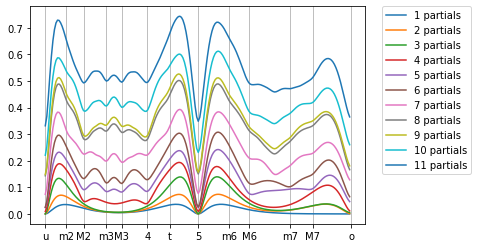

In [57]:
intervals = np.arange(1, 2, 0.005)

fig, ax = plt.subplots()

for nr in range(1, 12):
    ax.plot(intervals, np.vectorize(
        lambda interval: dissonancereduction.single_dissonance_and_gradient(
            [base_freq, base_freq * 3/2, base_freq * interval], [1, 1, 1],
            partials_pos[:nr], partials_vol[:nr]
        )[0]
    )(intervals), label='%i partials' % nr)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# reference intevals for the grid:
ju_intervals = [1, 16/15, 9/8, 6/5, 5/4, 4/3, 45/32, 3/2, 8/5, 5/3, 9/5, 15/8, 2]
et_intervals = [2**(i/12) for i in range(0,13)]
degree_names = ['u', 'm2', 'M2', 'm3', 'M3', '4', 't', '5', 'm6', 'M6', 'm7', 'M7', 'o']

ax.set_xticks(ju_intervals)
ax.set_xticklabels(degree_names)
ax.xaxis.grid(True)
plt.show()

## Examples

Lets look at some specific examples for tunings found by Dissonancereduction.

In [11]:
from adaptivetuning import Scale

In [12]:
et_scale = Scale()
ji_scale = Scale(reference_pitch=60, reference_frequency=260)
ji_scale.tune_all_by_interval([1, 16/15, 9/8, 6/5, 5/4, 4/3, 45/32, 3/2, 8/5, 5/3, 9/5, 15/8])
at_scale = Scale()

In [13]:
dissonancereduction = Dissonancereduction(method='CG', relative_bounds=None)
def adaptive_tuning(pitches):
    et_fundamentals = et_scale[pitches]
    fundamentals_vol = np.ones(len(pitches))
    partials_pos = list(range(1, len(partials_vol_piano) + 1))
    partials_vol = partials_vol_piano

    result = dissonancereduction.tune(np.array(et_fundamentals), np.array(fundamentals_vol),
                                      np.array(partials_pos), np.array(partials_vol),
                                      [], [])
    
    at_scale[pitches] = result.x

In [14]:
import sc3nb
sc = sc3nb.startup()
#sc = None

Starting sclang...
Done.
Starting osc communication...
This sc3nb sc instance is at port: 57130
Done.
Registering UDP callback...
Done.
Booting server...
Done.
-> sc3nb started


In [52]:
from adaptivetuning import Audiogenerator
a = Audiogenerator(sc = sc)
a.set_synth_def_with_dict(Audiogenerator.presets['piano'])
a.sustain_level = 1

In [25]:
def play(pitches):
    for p in pitches:
        a.note_on(p, 0.5)

#### C Major

In [26]:
pitches = [60, 60 + 4, 60 + 7]
adaptive_tuning(pitches)
print('ET:', freq_to_cent(et_scale[pitches]))
print('JI:', freq_to_cent(ji_scale[pitches]))
print('AT:', freq_to_cent(at_scale[pitches]))

ET: [0, 400, 700]
JI: [0, 386, 702]
AT: [0, 386, 701]


In [27]:
a.scale[pitches] = et_scale[pitches]

In [28]:
play(pitches)

In [29]:
a.scale[pitches] = ji_scale[pitches]

In [30]:
a.scale[pitches] = at_scale[pitches]

In [31]:
a.stop_all()

You could argue that the perfectly tunes JI version, at least with the synthetic sound being perfectly stable (other than an acoustic instrument it has no variation in amplitude or frequency), actually sounds "dead". The adaptive tuning version, since it is not perfectly just, has a bit of movement, but not as restless as the ET version.

#### C Minor

In [32]:
pitches = [60, 60 + 3, 60 + 7]
adaptive_tuning(pitches)
print('ET:', freq_to_cent(et_scale[pitches]))
print('JI:', freq_to_cent(ji_scale[pitches]))
print('AT:', freq_to_cent(at_scale[pitches]))

ET: [0, 300, 700]
JI: [0, 316, 702]
AT: [0, 316, 702]


In [190]:
a.scale[pitches] = et_scale[pitches]

In [185]:
play(pitches)

In [191]:
a.scale[pitches] = ji_scale[pitches]

In [192]:
a.scale[pitches] = at_scale[pitches]

In [193]:
a.stop_all()

#### C sus 2

The major second is to close to the tonic, the algorithm tries to push them away from each other at the cost of detuning the fifth.

In [53]:
pitches = [60, 60 + 2, 60 + 7]
adaptive_tuning(pitches)
print('ET:', freq_to_cent(et_scale[pitches]))
print('JI:', freq_to_cent(ji_scale[pitches]))
print('AT:', freq_to_cent(at_scale[pitches]))

ET: [0, 200, 700]
JI: [0, 204, 702]
AT: [0, 219, 712]


In [60]:
a.scale[pitches] = et_scale[pitches]

In [55]:
play(pitches)

In [59]:
a.scale[pitches] = ji_scale[pitches]

In [61]:
a.scale[pitches] = at_scale[pitches]

In [62]:
a.stop_all()

#### C sus 2$\flat$

For chords that contain intervals that are "too dissonant" the results of the adaptive tuning (without bounds) are extreme and unpredictable, in this case the tonic and the minor second 'explode' away from each other.

In [34]:
pitches = [60, 60 + 1, 60 + 7]
adaptive_tuning(pitches)
print('ET:', freq_to_cent(et_scale[pitches]))
print('JI:', freq_to_cent(ji_scale[pitches]))
print('AT:', freq_to_cent(at_scale[pitches]))

ET: [0, 100, 700]
JI: [0, 112, 702]
AT: [0, 2581, 2967]


In [207]:
a.scale[pitches] = et_scale[pitches]

In [205]:
play(pitches)

In [208]:
a.scale[pitches] = ji_scale[pitches]

In [209]:
a.scale[pitches] = at_scale[pitches]

In [210]:
a.stop_all()

We can prevent this by using an optimization methods that allows for bounds, this will reduce the flexibility of the optimization though.

In [36]:
dissonancereduction = Dissonancereduction(method='L-BFGS-B', relative_bounds=(2**(-1/24), 2**(1/24)))

In [37]:
pitches = [60, 60 + 1, 60 + 7]
adaptive_tuning(pitches)
print('ET:', freq_to_cent(et_scale[pitches]))
print('JI:', freq_to_cent(ji_scale[pitches]))
print('AT:', freq_to_cent(at_scale[pitches]))

ET: [0, 100, 700]
JI: [0, 112, 702]
AT: [0, 200, 702]


The algorithm pushes the tonic and the minor second as far from each other as it is allowed to (2 x 1/2 semitone).

To observe the 'unfiltered' behavior of the algorithm, we continue without bounds.

In [38]:
dissonancereduction = Dissonancereduction(method='CG', relative_bounds=None)

#### C sus 4

In [39]:
pitches = [60, 60 + 5, 60 + 7]
adaptive_tuning(pitches)
print('ET:', freq_to_cent(et_scale[pitches]))
print('JI:', freq_to_cent(ji_scale[pitches]))
print('AT:', freq_to_cent(at_scale[pitches]))

ET: [0, 500, 700]
JI: [0, 498, 702]
AT: [0, 493, 712]


In [216]:
a.scale[pitches] = et_scale[pitches]

In [213]:
play(pitches)

In [214]:
a.scale[pitches] = ji_scale[pitches]

In [217]:
a.scale[pitches] = at_scale[pitches]

In [218]:
a.stop_all()

#### C sus 4$\sharp$

similar to C sus 2$\flat$

In [40]:
pitches = [60, 60 + 6, 60 + 7]
adaptive_tuning(pitches)
print('ET:', freq_to_cent(et_scale[pitches]))
print('JI:', freq_to_cent(ji_scale[pitches]))
print('AT:', freq_to_cent(at_scale[pitches]))

ET: [0, 600, 700]
JI: [0, 590, 702]
AT: [0, 492, 712]


In [220]:
a.scale[pitches] = et_scale[pitches]

In [221]:
play(pitches)

In [222]:
a.scale[pitches] = ji_scale[pitches]

In [223]:
a.scale[pitches] = at_scale[pitches]

In [224]:
a.stop_all()

#### C maj 7

In [41]:
pitches = [60, 60 + 4, 60 + 7, 60 + 11]
adaptive_tuning(pitches)
print('ET:', freq_to_cent(et_scale[pitches]))
print('JI:', freq_to_cent(ji_scale[pitches]))
print('AT:', freq_to_cent(at_scale[pitches]))

ET: [0, 400, 700, 1100]
JI: [0, 386, 702, 1088]
AT: [0, 381, 698, 1079]


In [234]:
a.scale[pitches] = et_scale[pitches]

In [227]:
play(pitches)

In [230]:
a.scale[pitches] = ji_scale[pitches]

In [235]:
a.scale[pitches] = at_scale[pitches]

In [236]:
a.stop_all()

#### C min 7

In [43]:
pitches = [60, 60 + 3, 60 + 7, 60 + 10]
adaptive_tuning(pitches)
print('ET:', freq_to_cent(et_scale[pitches]))
print('JI:', freq_to_cent(ji_scale[pitches]))
print('AT:', freq_to_cent(at_scale[pitches]))

ET: [0, 300, 700, 1000]
JI: [0, 316, 702, 1018]
AT: [0, 316, 702, 1018]


In [242]:
a.scale[pitches] = et_scale[pitches]

In [239]:
play(pitches)

In [240]:
a.scale[pitches] = ji_scale[pitches]

In [243]:
a.scale[pitches] = at_scale[pitches]

In [244]:
a.stop_all()

#### C7

Dissonant minor seventh gets pushed down into the local minimum between the major sixth and the minor seventh that can be seen in the dissonance curves.

In [44]:
pitches = [60, 60 + 4, 60 + 7, 60 + 10]
adaptive_tuning(pitches)
print('ET:', freq_to_cent(et_scale[pitches]))
print('JI:', freq_to_cent(ji_scale[pitches]))
print('AT:', freq_to_cent(at_scale[pitches]))

ET: [0, 400, 700, 1000]
JI: [0, 386, 702, 1018]
AT: [0, 387, 703, 968]


In [246]:
a.scale[pitches] = et_scale[pitches]

In [247]:
play(pitches)

In [248]:
a.scale[pitches] = ji_scale[pitches]

In [249]:
a.scale[pitches] = at_scale[pitches]

In [250]:
a.stop_all()

#### C major pentatonic cluster

It is not possible to tune this chord justly with all fifth = 3/2, all fourth = 4/3 and all major thirds = 5/4. The JI-tuning is even worth than the equal tempered tuning here because the fifth d-a is flat by the syntotic comma. Adaptive tuning provides arguably the best compromise.

In [45]:
pitches = [60, 60 + 2, 60 + 4, 60 + 7, 60 + 9]
adaptive_tuning(pitches)
print('ET:', freq_to_cent(et_scale[pitches]))
print('JI:', freq_to_cent(ji_scale[pitches]))
print('AT:', freq_to_cent(at_scale[pitches]))

ET: [0, 200, 400, 700, 900]
JI: [0, 204, 386, 702, 884]
AT: [0, 191, 392, 693, 893]


In [260]:
a.scale[pitches] = et_scale[pitches]

In [253]:
play(pitches)

In [262]:
a.scale[pitches] = ji_scale[pitches]

In [261]:
a.scale[pitches] = at_scale[pitches]

In [263]:
a.stop_all()